<a href="https://colab.research.google.com/github/neta-caspi/advanced-ml-final-proj/blob/main/Advanced_ML_Final_Project_Rotem_%26_Neta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import csv
import math


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Original paper code (compiled with Python 3) but used only for some data (see Data-Sets section)
!git clone https://github.com/neta-caspi/advanced-ml-final-proj-original-paper-code.git

Cloning into 'advanced-ml-final-proj-original-paper-code'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 121 (delta 3), reused 121 (delta 3), pack-reused 0
Receiving objects: 100% (121/121), 18.52 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
# below might be required for a newer Numpy version (to overcome some error).
#! pip uninstall numpy
#! pip install numpy

## Data-Sets

Part of the original paper data resides within its Github project (see above)
Main parts, including the historical database of texts and embeddings are taken from [here](http://snap.stanford.edu/historical_embeddings/).

While reading this data from the remote location works for *.pkl files, it doesn't work for the numpy files (*.npy).
* This works: pd.read_pickle("http://snap.stanford.edu/historical_embeddings/eng-all/svd/1840-vocab.pkl")

* But this fails: np.load("http://snap.stanford.edu/historical_embeddings/eng-all/svd/1840-w.npy")

For this reaosn, we downloaded all the embeddings and word counts to google drive (too big to load to GitHub).

In order to reconstract part of the paper results, we used the eng-all data-set.
We used both the SVD and SGNS versions of embeddings.


In [ ]:
 ### This might requires to be updated to your gdrive location (after the share we did)
gdrive_data_root = "/content/gdrive/MyDrive/Colab Notebooks/Embedding-Dynamics-Judaism/" #Rotem
# gdrive_data_root = "/content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/" #Neta
gdrive_data_words_groups = gdrive_data_root + "words_group/"
pkl_vocab_file_postfix = "-vocab.pkl"
npy_vec_file_postfix = "-w.npy"

internal_data_root = "/content/advanced-ml-final-proj-original-paper-code/data/"
internal_vocab_dir = internal_data_root + "vocab_counts/"
vocab_file_prefix = "vocab_"

occup_gender_file = internal_data_root + "occupation_percentages_gender_occ1950.csv"
occup_race_file = internal_data_root + "occupation_percentages_race_occ1950.csv"


In [ ]:
from enum import Enum

class Embedding(Enum):
  SGNS = "sgns"
  SVD = "svd"

  def __str__(self):
    return self.value


class DataRootPath(Enum):
  INTERNAL = internal_data_root
  GDRIVE = gdrive_data_words_groups

  def get(self, words_group_name):
    return self.value + words_group_name + ".txt"


class WordsGroup:
  
  def __init__(self, name, data_root_path: DataRootPath):
    self.name = name
    self.data_root_path = data_root_path

  def full_path(self):
    return self.data_root_path.get(self.name)
  
  def name_ext(self, embedding: Embedding):
    return self.name + '(' + str(embedding) + ')'


years = range(1910, 2000, 10)


In [ ]:
# Words Groups information:

# Adjectiuves (original paper)
adjectives_appearance_origin =          WordsGroup('adjectives_appearance', DataRootPath.INTERNAL)
adjectives_intelligencegeneral_origin = WordsGroup('adjectives_intelligencegeneral', DataRootPath.INTERNAL)
adjectives_otherization_origin =        WordsGroup('adjectives_otherization', DataRootPath.INTERNAL)

adjectives_words_groups = [adjectives_appearance_origin, adjectives_intelligencegeneral_origin, adjectives_otherization_origin] #...

# Gender (original paper)
female_pairs_origin =   WordsGroup('female_pairs', DataRootPath.INTERNAL)
male_pairs_origin =     WordsGroup('male_pairs', DataRootPath.INTERNAL)

gender_words_groups = [female_pairs_origin, male_pairs_origin ]

# Names (original paper)
names_asian_origin =    WordsGroup('names_asian', DataRootPath.INTERNAL)
names_black_origin =    WordsGroup('names_black', DataRootPath.INTERNAL)
names_chinese_origin =  WordsGroup('names_chinese', DataRootPath.INTERNAL)
names_hispanic_origin = WordsGroup('names_hispanic', DataRootPath.INTERNAL)
names_russian_origin =  WordsGroup('names_russian', DataRootPath.INTERNAL)
names_white_origin =    WordsGroup('names_white', DataRootPath.INTERNAL)

name_words_groups = [names_asian_origin, names_black_origin, names_chinese_origin, names_hispanic_origin, names_russian_origin, names_white_origin]

# Occupations (original paper)
occupation_words_origin =       WordsGroup('occupations1950', DataRootPath.INTERNAL)
occupation_prof_words_origin =  WordsGroup('occupations1950_professional', DataRootPath.INTERNAL)
occupation_mturk_words_origin = WordsGroup('occupationsMturk', DataRootPath.INTERNAL)

occupations_words_groups = [occupation_words_origin, occupation_prof_words_origin, occupation_mturk_words_origin ]


Graphes functions:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ChartInfo:
  def __init__(self, name, x, y):
    self.name = name
    self.x = x
    self.y = y
  
  def __init__(self, name, dict):
    self.name = name
    self.x = list(dict.keys())
    self.y = list(dict.values())


def plot_chart(title, xlabel, ylabel, chart_info):
  return plot_charts(title, xlabel, ylabel, [chart_info])

def plot_charts(title, xlabel, ylabel, charts_info):
  _legend = []
  for chart_info in charts_info:
    plt.plot(chart_info.x, chart_info.y)
    _legend.append(chart_info.name)
 
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if len(_legend) >= 2:
    plt.legend(_legend, loc='upper left')
  plt.figure()


## Vocab Frequencies

In [ ]:
def internal_vocab_file_name(embedding: Embedding, year):
  return internal_vocab_dir + vocab_file_prefix + str(embedding) + str(year) + ".txt"

def internal_words_group_file_name(words_group_name):
  return internal_data_root + words_group_name + ".txt"

def gdrive_words_group_file_name(words_group_name):
  return internal_data_root + words_group_name + ".txt"

def gdrive_vocab_pkl_file_name(embedding: Embedding, year):
  return gdrive_data_root + "eng-all/" + str(embedding) + "/" + str(year) + pkl_vocab_file_postfix

def gdrive_vocab_npy_file_name(embedding: Embedding, year):
  return gdrive_data_root + "eng-all/" + str(embedding) + "/" + str(year) + npy_vec_file_postfix


In [ ]:
def word_count_avg(words, words_count_dict, dict_file_name, normalize):
  num_words = len(words)
  count_sum = 0.0
  for word in words:
    count = words_count_dict.get(word)
    if count is None:
      # print("word " + word + " doesn't appear in " + dict_file_name)
      count = 0
    count_sum += count
  avg_count = count_sum / num_words

  if normalize:
    all_words_num = len(words_count_dict)
    all_words_count = sum(words_count_dict.values())
    all_words_avg_count = all_words_count / all_words_num
    #print("********** ", dict_file_name, " ***********")
    #print("Initial avg_count: ", avg_count)
    avg_count = avg_count / all_words_avg_count
    #print("all_words_num: ", all_words_num, ", all_words_count: ", all_words_count, ", all_words_avg_count: ", all_words_avg_count)
    #print("Normalized avg_count: ", avg_count)
  
  return avg_count


In [ ]:
def words_count_avg_per_year(words_groups, embedding: Embedding, years, normalize=False):
  words_groups_to_yearly_avg_count = {}
  for words_group in words_groups:
    words_group_file = words_group.full_path()
    words = [ word.lower().strip() for word in open(words_group_file) ]
    avg_words_count_per_year = {}
    for year in years:
      yearly_vocab_file_name = internal_vocab_file_name(embedding, year)
      yearly_vocab_dict = { line.split()[0] : float(line.split()[1]) for line in open(yearly_vocab_file_name) }
      avg_words_count_per_year[year] = word_count_avg(words, yearly_vocab_dict, yearly_vocab_file_name, normalize)
    
    words_group_name = words_group.name_ext(embedding)
    words_groups_to_yearly_avg_count[words_group_name] = avg_words_count_per_year
  
  return words_groups_to_yearly_avg_count



### Average counts of Neutral Words in a list in the eng-all embeddings over time

In [ ]:
adjectives_sgns_words_groups_to_yearly_avg_count = words_count_avg_per_year(adjectives_words_groups, Embedding.SGNS, years)
[print(key,':',value) for key, value in adjectives_sgns_words_groups_to_yearly_avg_count.items()]
print('\n')
adjectives_svd_words_groups_to_yearly_avg_count = words_count_avg_per_year(adjectives_words_groups, Embedding.SVD, years)
[print(key,':',value) for key, value in adjectives_svd_words_groups_to_yearly_avg_count.items()]
print('\n')

adjectives_appearance(sgns) : {1910: 56231.9, 1920: 48235.76, 1930: 39105.34, 1940: 36523.8, 1950: 50871.26, 1960: 84613.18, 1970: 100976.84, 1980: 130213.16, 1990: 208316.94}
adjectives_intelligencegeneral(sgns) : {1910: 22071.535714285714, 1920: 20064.035714285714, 1930: 16830.0, 1940: 15015.642857142857, 1950: 21609.803571428572, 1960: 36624.57142857143, 1970: 40522.19642857143, 1980: 46163.642857142855, 1990: 71400.30357142857}
adjectives_otherization(sgns) : {1910: 5178.775, 1920: 5029.625, 1930: 3966.1, 1940: 3878.275, 1950: 5758.575, 1960: 10772.35, 1970: 13363.025, 1980: 16336.15, 1990: 25496.85}


adjectives_appearance(svd) : {1910: 56231.9, 1920: 48235.76, 1930: 39105.34, 1940: 36523.8, 1950: 50871.26, 1960: 84613.18, 1970: 100976.84, 1980: 130213.16, 1990: 208316.94}
adjectives_intelligencegeneral(svd) : {1910: 22071.535714285714, 1920: 20064.035714285714, 1930: 16830.0, 1940: 15015.642857142857, 1950: 21609.803571428572, 1960: 36624.57142857143, 1970: 40522.19642857143, 198

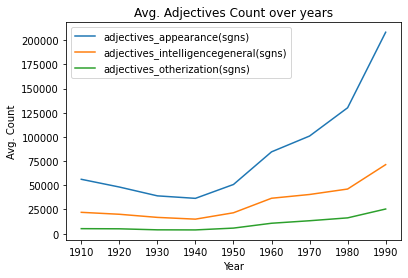

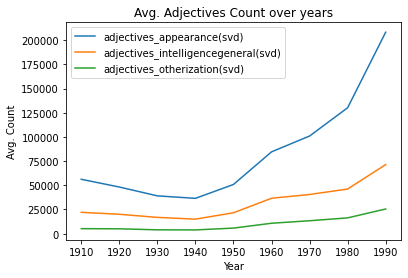

<Figure size 432x288 with 0 Axes>

In [ ]:
sgns_charts_info = [ChartInfo(key, value) for key, value in adjectives_sgns_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Adjectives Count over years', 'Year', 'Avg. Count', sgns_charts_info)

svd_charts_info = [ChartInfo(key, value) for key, value in adjectives_svd_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Adjectives Count over years', 'Year', 'Avg. Count', svd_charts_info)

adjectives_appearance(sgns) : {1910: 1.9078827101960838, 1920: 1.764306235493843, 1930: 1.5576955091947533, 1940: 1.4827131800712818, 1950: 1.3773822177602197, 1960: 1.2984873076911985, 1970: 1.2475569235764346, 1980: 1.3032241224875813, 1990: 1.3781451276425543}
adjectives_intelligencegeneral(sgns) : {1910: 0.7488614358889008, 1920: 0.7338767611391517, 1930: 0.6703947701195719, 1940: 0.6095721576486814, 1950: 0.5851036355021874, 1960: 0.56204649381609, 1970: 0.5006469474880434, 1980: 0.4620237536154571, 1990: 0.47235707513351316}
adjectives_otherization(sgns) : {1910: 0.17570978897201983, 1920: 0.18396722161516102, 1930: 0.15798292916050113, 1940: 0.15744170810378302, 1950: 0.15591826907056278, 1960: 0.16531419512902462, 1970: 0.16509859447646594, 1980: 0.16349856457346937, 1990: 0.16867739895628775}


adjectives_appearance(svd) : {1910: 0.7006290979123219, 1920: 0.6318933553972071, 1930: 0.5395586955068847, 1940: 0.5099407140431859, 1950: 0.5779403469840912, 1960: 0.706443030746753, 

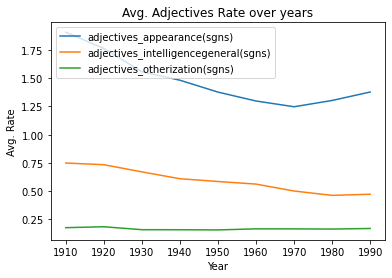

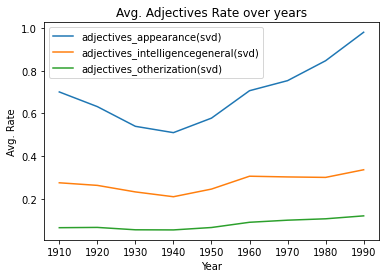

<Figure size 432x288 with 0 Axes>

In [ ]:
# Now, normalize to corpus size:

adjectives_sgns_words_groups_to_yearly_avg_count = words_count_avg_per_year(adjectives_words_groups, Embedding.SGNS, years, normalize=True)
[print(key,':',value) for key, value in adjectives_sgns_words_groups_to_yearly_avg_count.items()]
print('\n')
adjectives_svd_words_groups_to_yearly_avg_count = words_count_avg_per_year(adjectives_words_groups, Embedding.SVD, years, normalize=True)
[print(key,':',value) for key, value in adjectives_svd_words_groups_to_yearly_avg_count.items()]
print('\n')

sgns_charts_info = [ChartInfo(key, value) for key, value in adjectives_sgns_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Adjectives Rate over years', 'Year', 'Avg. Rate', sgns_charts_info)

svd_charts_info = [ChartInfo(key, value) for key, value in adjectives_svd_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Adjectives Rate over years', 'Year', 'Avg. Rate', svd_charts_info)


### Average counts of Group Words (Gender and Race related) in a list in the eng-all embeddings over time

In [ ]:
gender_sgns_words_groups_to_yearly_avg_count = words_count_avg_per_year(gender_words_groups, Embedding.SGNS, years)
[print(key,':',value) for key, value in gender_sgns_words_groups_to_yearly_avg_count.items()]
print('\n')

name_words_groups_to_yearly_avg_count = words_count_avg_per_year(name_words_groups, Embedding.SGNS, years)
[print(key,':',value) for key, value in name_words_groups_to_yearly_avg_count.items()]
print('\n')

female_pairs(sgns) : {1910: 769143.65, 1920: 729429.025, 1930: 635999.85, 1940: 540830.3, 1950: 749410.1, 1960: 1110819.8, 1970: 1610053.95, 1980: 2980188.45, 1990: 5425153.825}
male_pairs(sgns) : {1910: 3141951.975, 1920: 2941354.125, 1930: 2611906.85, 1940: 2300660.375, 1950: 3352361.9, 1960: 5567057.25, 1970: 6201595.05, 1980: 7312107.9, 1990: 10929249.475}


names_asian(sgns) : {1910: 1805.95, 1920: 2376.95, 1930: 2915.725, 1940: 2967.125, 1950: 6968.55, 1960: 18138.375, 1970: 26447.55, 1980: 34504.275, 1990: 56367.775}
names_black(sgns) : {1910: 26024.375, 1920: 26683.825, 1930: 27028.65, 1940: 27811.275, 1950: 43545.65, 1960: 93735.5, 1970: 132841.85, 1980: 174531.025, 1990: 267635.75}
names_chinese(sgns) : {1910: 1400.0294117647059, 1920: 1886.764705882353, 1930: 2633.9117647058824, 1940: 2358.4117647058824, 1950: 5317.941176470588, 1960: 13577.411764705883, 1970: 21378.20588235294, 1980: 28827.529411764706, 1990: 51607.05882352941}
names_hispanic(sgns) : {1910: 1428.625, 1920: 

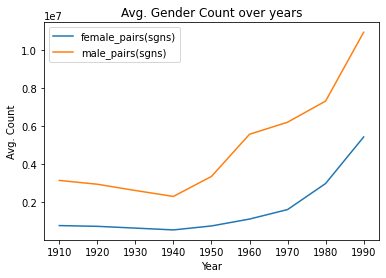

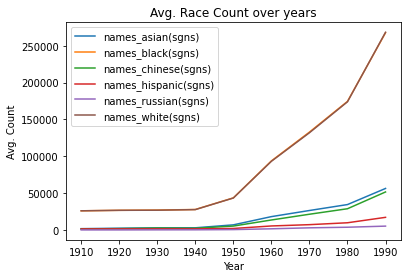

<Figure size 432x288 with 0 Axes>

In [ ]:
gender_charts_info = [ChartInfo(key, value) for key, value in gender_sgns_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Gender Count over years', 'Year', 'Avg. Count', gender_charts_info)

name_charts_info = [ChartInfo(key, value) for key, value in name_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Race Count over years', 'Year', 'Avg. Count', name_charts_info)

female_pairs(sgns) : {1910: 26.09614598639043, 1920: 26.680126469608737, 1930: 25.333985337898525, 1940: 21.955443135487144, 1950: 20.290909750415224, 1960: 17.046817191270623, 1970: 19.89202625724955, 1980: 29.82688906097414, 1990: 35.890740861665485}
male_pairs(sgns) : {1910: 106.60276194418005, 1920: 107.58510747074445, 1930: 104.04092051571511, 1940: 93.39716735061077, 1950: 90.76802242674673, 1960: 85.43294532028305, 1970: 76.61997386573837, 1980: 73.18242949876964, 1990: 72.30373061720854}


names_asian(sgns) : {1910: 0.061273774858729965, 1920: 0.08694105175200079, 1930: 0.11614300600753943, 1940: 0.12045283744897853, 1950: 0.18867936146211003, 1960: 0.27835438544731855, 1970: 0.3267563543693181, 1980: 0.3453322498965941, 1990: 0.3729076208219158}
names_black(sgns) : {1910: 0.8829766574872839, 1920: 0.9760069880587866, 1930: 1.0766408558165401, 1940: 1.1290211861056882, 1950: 1.1790351560156032, 1960: 1.4384798802041048, 1970: 1.6412453559469895, 1980: 1.746774610972371, 1990: 1

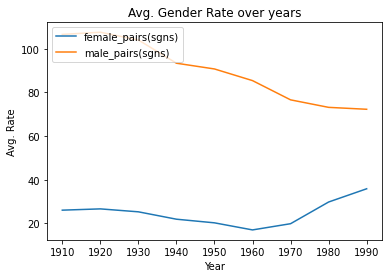

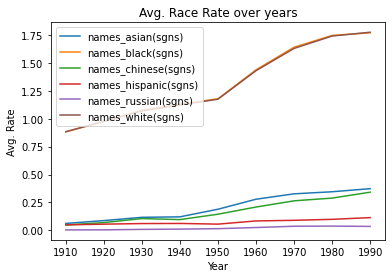

<Figure size 432x288 with 0 Axes>

In [ ]:
# Now, normalize to corpus size:

gender_sgns_words_groups_to_yearly_avg_count = words_count_avg_per_year(gender_words_groups, Embedding.SGNS, years, normalize=True)
[print(key,':',value) for key, value in gender_sgns_words_groups_to_yearly_avg_count.items()]
print('\n')

name_words_groups_to_yearly_avg_count = words_count_avg_per_year(name_words_groups, Embedding.SGNS, years, normalize=True)
[print(key,':',value) for key, value in name_words_groups_to_yearly_avg_count.items()]
print('\n')

gender_charts_info = [ChartInfo(key, value) for key, value in gender_sgns_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Gender Rate over years', 'Year', 'Avg. Rate', gender_charts_info)

name_charts_info = [ChartInfo(key, value) for key, value in name_words_groups_to_yearly_avg_count.items()]
plot_charts('Avg. Race Rate over years', 'Year', 'Avg. Rate', name_charts_info)


## Embedding Bias

In [ ]:
def vec_mean(vec_list):
  return np.mean(vec_list, axis=0)


def vec_dist(vec1, vec2):
  return np.linalg.norm(vec1 - vec2)


def vec_to_vec_list_dist(vec, vec_list):
  dists = []
  for vec2 in vec_list:
    dists.append(vec_dist(vec, vec2))
  
  return np.mean(dists)


def word_to_vec_dict(embedding: Embedding, year):
  yearly_words_file = gdrive_vocab_pkl_file_name(embedding, year)
  yearly_words_vec_file = gdrive_vocab_npy_file_name(embedding, year)
  yearly_words = pd.read_pickle(yearly_words_file)
  yearly_words_vec = np.load(yearly_words_vec_file)
  return { yearly_words[i]: yearly_words_vec[i] for i in range(len(yearly_words)) }, yearly_words_file


def word_to_vec(words_group, embedding: Embedding, year):
  word_to_vec_all, _ = word_to_vec_dict(embedding, year)

  words_group_file = words_group.full_path()
  words = [ word.lower().strip() for word in open(words_group_file) ]
  word_to_vec = {}
  for word in words:
    try:
      vec = word_to_vec_all[word]
      word_to_vec[word] = vec
    except KeyError:
      pass

  return word_to_vec


In [ ]:
def word_groups_vec_dist(neutral_words_group, words_group_a, words_group_b, embedding: Embedding, years):
  group_a_dist_per_year = {}
  for year in years:
    print("Calculating distance for " + str(year) + "...")
    neutral_words_to_vec = word_to_vec(neutral_words_group, embedding, year)
    group_a_words_to_vec = word_to_vec(words_group_a, embedding, year)
    group_b_words_to_vec = word_to_vec(words_group_b, embedding, year)

    group_a_mean_vec = vec_mean(list(group_a_words_to_vec.values()))
    group_b_mean_vec = vec_mean(list(group_b_words_to_vec.values()))

    group_a_dist = vec_to_vec_list_dist(group_a_mean_vec, neutral_words_to_vec.values())
    group_b_dist = vec_to_vec_list_dist(group_b_mean_vec, neutral_words_to_vec.values())
    group_a_dist_per_year[year] = group_a_dist - group_b_dist
  
  return group_a_dist_per_year


### Embedding Bias of a given neutral words group between gender over time

In [ ]:
# Occupation: Male vs. Female:

gender_dist_per_year = word_groups_vec_dist(occupation_prof_words_origin, male_pairs_origin, female_pairs_origin, Embedding.SVD, years)
print(gender_dist_per_year)

Calculating distance for 1910...
Calculating distance for 1920...
Calculating distance for 1930...
Calculating distance for 1940...
Calculating distance for 1950...
Calculating distance for 1960...
Calculating distance for 1970...
Calculating distance for 1980...
Calculating distance for 1990...
{1910: -0.08152181939167735, 1920: -0.08262527773844575, 1930: -0.0812332730101386, 1940: -0.08361938998270446, 1950: -0.08968009083168949, 1960: -0.09564422990129118, 1970: -0.08055221740619944, 1980: -0.06334474071547236, 1990: -0.05240756246568501}


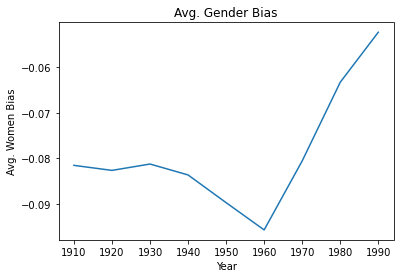

<Figure size 432x288 with 0 Axes>

In [ ]:
gender_chart_info = ChartInfo('Avg. Gender Bias', gender_dist_per_year)
plot_chart('Avg. Gender Bias', 'Year', 'Avg. Women Bias', gender_chart_info)

### Embedding Bias of a given neutral words group between races over time

In [ ]:
# Occupation: White vs. Asian:
asian_dist_per_year = word_groups_vec_dist(occupation_prof_words_origin, names_white_origin, names_asian_origin, Embedding.SVD, years)
print(asian_dist_per_year)


Calculating distance for 1910...
Calculating distance for 1920...
Calculating distance for 1930...
Calculating distance for 1940...
Calculating distance for 1950...
Calculating distance for 1960...
Calculating distance for 1970...
Calculating distance for 1980...
Calculating distance for 1990...
{1910: -0.004475898575559745, 1920: -0.0432363263088702, 1930: -0.05164827766167024, 1940: -0.06745288563950891, 1950: -0.03928737353885747, 1960: -0.037003215481830054, 1970: -0.027555113963870337, 1980: -0.0020072399831938537, 1990: -0.009957014499898387}


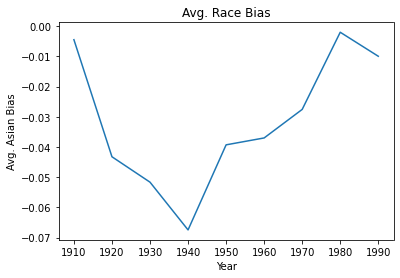

<Figure size 432x288 with 0 Axes>

In [ ]:
asian_chart_info = ChartInfo('Avg. Race Bias', asian_dist_per_year)
plot_chart('Avg. Race Bias', 'Year', 'Avg. Asian Bias', asian_chart_info)


## Gender and Race Census Occupation rates

2 versions: non relative (with or without logit_prop) and relative (can be negative thus no logit_prop option)

In [ ]:
def logit_prop(p):
  return math.log(p/(1-p))


def gender_occup_percent_per_year(occup, years, apply_logit_prop):
  df = pd.read_csv(occup_gender_file)
  occup_per_year = {}
  for year in years:
    p = df.loc[(df['Census year'] == year) & (df['Occupation'] == occup), 'Female'].mean()
    if apply_logit_prop:
      p = logit_prop(p)
    occup_per_year[year] = p
  return occup_per_year


def gender_occup_relative_percent_per_year(occup, years):
  df = pd.read_csv(occup_gender_file)
  occup_per_year = {}
  for year in years:
    # female - male = female - (1 - female) = 2 * female - 1
    p = df.loc[(df['Census year'] == year) & (df['Occupation'] == occup), 'Female'].mean()
    p = ((2 * p) - 1) * 100
    # male_series = df.loc[(df['Census year'] == year) & (df['Occupation'] == occup), 'Male']
    # p = (female_series - male_series).mean() * 100
    occup_per_year[year] = p
  return occup_per_year


def gender_all_occups_percent_per_year(years, apply_logit_prop):
  df = pd.read_csv(occup_gender_file)
  all_occup_per_year = {}
  for year in years:
    p = df.loc[df['Census year'] == year, 'Female'].mean()
    if apply_logit_prop:
      p = logit_prop(p)
    all_occup_per_year[year] = p
  return all_occup_per_year
  

def gender_all_occups_relative_percent_per_year(years):
  df = pd.read_csv(occup_gender_file)
  all_occup_per_year = {}
  for year in years:
    p = df.loc[df['Census year'] == year, 'Female'].mean()
    p = ((2 * p) - 1) * 100
    all_occup_per_year[year] = p
  return all_occup_per_year


def gender_all_occups_percent(years, apply_logit_prop):
  df = pd.read_csv(occup_gender_file)
  p = df.loc[df['Census year'].isin(list(years)), 'Female'].mean()
  if apply_logit_prop:
    p = logit_prop(p)
  return p


def gender_all_occups_relative_percent(years):
  df = pd.read_csv(occup_gender_file)
  p = df.loc[df['Census year'].isin(list(years)), 'Female'].mean()
  p = ((2 * p) - 1) * 100
  return p


In [ ]:
def cond_logit_prop(p1, p2):
  return logit_prop(p1 / (p1 + p2))


def race_occup_percent_per_year(race, occup, years, apply_logit_prop, relative_race = 'white'):
  df = pd.read_csv(occup_race_file)
  occup_per_year = {}
  for year in years:
    p1 = df.loc[(df['Census year'] == year) & (df['Occupation'] == occup), race].mean()
    p = p1
    if apply_logit_prop:
      p2 = df.loc[(df['Census year'] == year) & (df['Occupation'] == occup), relative_race].mean()
      p = cond_logit_prop(p1, p2)
    occup_per_year[year] = p
  return occup_per_year


def race_occup_relative_percent_per_year(race, occup, years, relative_race = 'white'):
  df = pd.read_csv(occup_race_file)
  occup_per_year = {}
  for year in years:
    race_series = df.loc[(df['Census year'] == year) & (df['Occupation'] == occup), race]
    relative_race_series = df.loc[(df['Census year'] == year) & (df['Occupation'] == occup), relative_race]
    p = (race_series - relative_race_series).mean() * 100
    occup_per_year[year] = p
  return occup_per_year


def race_all_occups_percent_per_year(race, years, apply_logit_prop, relative_race = 'white'):
  df = pd.read_csv(occup_race_file)
  all_occup_per_year = {}
  for year in years:
    p1 = df.loc[df['Census year'] == year, race].mean()
    p = p1
    if apply_logit_prop:
      p2 = df.loc[df['Census year'] == year, relative_race].mean()
      p = cond_logit_prop(p1, p2)
    all_occup_per_year[year] = p
  return all_occup_per_year


def race_all_occups_relative_percent_per_year(race, years, relative_race = 'white'):
  df = pd.read_csv(occup_race_file)
  all_occup_per_year = {}
  for year in years:
    race_series = df.loc[df['Census year'] == year, race]
    relative_race_series = df.loc[df['Census year'] == year, relative_race]
    p = (race_series - relative_race_series).mean() * 100
    all_occup_per_year[year] = p
  return all_occup_per_year


In [ ]:
years = range(1910, 2000, 10)


### Specific Occupation, Per Year for both Gender and Race (relative or not and with/without logit_prop)

In [ ]:
apply_logit_prop = False # can be set to True

teacher_per_years_female_mean = gender_occup_percent_per_year("teacher", years, apply_logit_prop)
print("teacher: ", teacher_per_years_female_mean)

engineer_per_years_female_mean = gender_occup_percent_per_year("engineer", years, apply_logit_prop)
print("engineer: ", engineer_per_years_female_mean)


teacher:  {1910: 0.7957860473762761, 1920: 0.8373972240362563, 1930: 0.8116073542896325, 1940: 0.7474501500241553, 1950: 0.7446611083061556, 1960: 0.7694241844384666, 1970: 0.7391928688513486, 1980: 0.7161517431159874, 1990: 0.7439580297756162}
engineer:  {1910: 0.001836571246703172, 1920: 0.0015112556317028042, 1930: 0.006289495790905207, 1940: 0.00977273024833022, 1950: 0.014017321664352414, 1960: 0.00960499276961717, 1970: 0.01793458059719985, 1980: 0.06015052930018154, 1990: 0.11629365157906454}


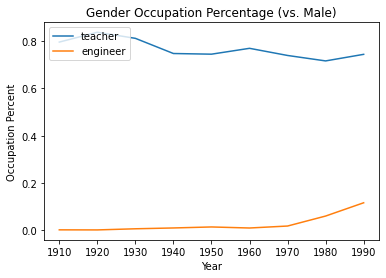

<Figure size 432x288 with 0 Axes>

In [ ]:
teacher_chart_info = ChartInfo('teacher', teacher_per_years_female_mean)
engineer_chart_info = ChartInfo('engineer', engineer_per_years_female_mean)

plot_charts('Gender Occupation Percentage (vs. Male)', 'Year', 'Occupation Percent', [teacher_chart_info, engineer_chart_info])


In [ ]:
# Relative
teacher_per_years_female_mean = gender_occup_relative_percent_per_year("teacher", years)
print("teacher: ", teacher_per_years_female_mean)

engineer_per_years_female_mean = gender_occup_relative_percent_per_year("engineer", years)
print("engineer: ", engineer_per_years_female_mean)

teacher:  {1910: 59.15720947525522, 1920: 67.47944480725126, 1930: 62.3214708579265, 1940: 49.490030004831056, 1950: 48.932221661231125, 1960: 53.884836887693325, 1970: 47.83857377026972, 1980: 43.23034862319748, 1990: 48.79160595512324}
engineer:  {1910: -99.63268575065936, 1920: -99.69774887365944, 1930: -98.74210084181895, 1940: -98.04545395033396, 1950: -97.19653566712951, 1960: -98.07900144607656, 1970: -96.41308388056002, 1980: -87.96989413996369, 1990: -76.74126968418709}


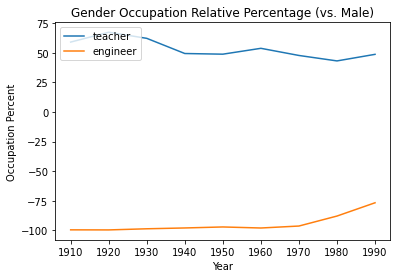

<Figure size 432x288 with 0 Axes>

In [ ]:
teacher_chart_info = ChartInfo('teacher', teacher_per_years_female_mean)
engineer_chart_info = ChartInfo('engineer', engineer_per_years_female_mean)

plot_charts('Gender Occupation Relative Percentage (vs. Male)', 'Year', 'Occupation Percent', [teacher_chart_info, engineer_chart_info])


In [ ]:
apply_logit_prop = True # can be set to False

teacher_per_years_hispanic_mean = race_occup_percent_per_year("hispanic", "engineer", years, apply_logit_prop)
print("hispanic: ", teacher_per_years_hispanic_mean)

engineer_per_years_black_mean = race_occup_percent_per_year("black", "engineer", years, apply_logit_prop)
print("black: ", engineer_per_years_black_mean)

hispanic:  {1910: -5.592854895831354, 1920: -5.379446201726423, 1930: -5.13315887029662, 1940: -5.262373184461322, 1950: -4.878229453573142, 1960: -4.378122514777813, 1970: -4.010624645081053, 1980: -3.6497317817713713, 1990: -3.3172715745955657}
black:  {1910: -4.517801389035936, 1920: -4.645612273233028, 1930: -4.955978098089973, 1940: -4.677847835128214, 1950: -4.701647886632909, 1960: -4.82690649760482, 1970: -4.169875080973696, 1980: -3.266838348626962, 1990: -3.042133926871644}


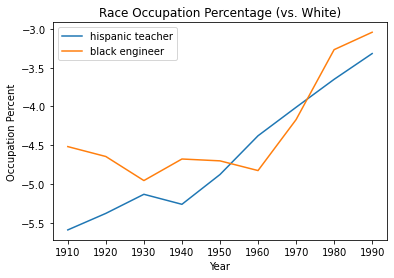

<Figure size 432x288 with 0 Axes>

In [ ]:
teacher_hispanic_chart_info = ChartInfo('hispanic teacher', teacher_per_years_hispanic_mean)
engineer_black_chart_info = ChartInfo('black engineer', engineer_per_years_black_mean)

plot_charts('Race Occupation Percentage (vs. White)', 'Year', 'Occupation Percent', [teacher_hispanic_chart_info, engineer_black_chart_info])


In [ ]:
# Relative (by default vs. 'white' group. Can be changed via a parameter)

teacher_per_years_hispanic_mean = race_occup_relative_percent_per_year("hispanic", "engineer", years)
print("hispanic: ", teacher_per_years_hispanic_mean)

engineer_per_years_black_mean = race_occup_relative_percent_per_year("black", "engineer", years)
print("black: ", engineer_per_years_black_mean)

hispanic:  {1910: -97.90803056430217, 1920: -98.05882394147395, 1930: -97.99093296077956, 1940: -98.00655006724013, 1950: -97.51083456242458, 1960: -96.06210518304286, 1970: -93.47974228720109, 1980: -87.87810798131642, 1990: -83.67619589554548}
black:  {1910: -97.20157673815555, 1920: -97.56692157385864, 1930: -97.87823627028136, 1940: -97.60105190114673, 1950: -97.3664116065605, 1960: -96.50353908212193, 1970: -93.73373807458803, 1980: -86.78381300099946, 1990: -82.6793456747362}


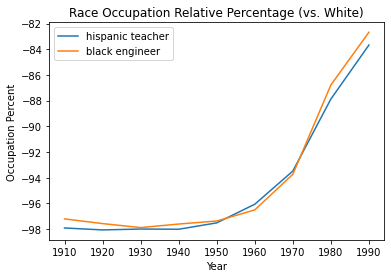

<Figure size 432x288 with 0 Axes>

In [ ]:
teacher_hispanic_chart_info = ChartInfo('hispanic teacher', teacher_per_years_hispanic_mean)
engineer_black_chart_info = ChartInfo('black engineer', engineer_per_years_black_mean)

plot_charts('Race Occupation Relative Percentage (vs. White)', 'Year', 'Occupation Percent', [teacher_hispanic_chart_info, engineer_black_chart_info])


### Mean all years

In [ ]:
apply_logit_prop = False

all_occups_all_years_female_mean = gender_all_occups_percent(years, apply_logit_prop)
print("female: ", all_occups_all_years_female_mean)

all_occups_all_years_female_mean = gender_all_occups_percent_per_year(years, apply_logit_prop)
print("female: ", all_occups_all_years_female_mean)

female:  0.2352832439462348
female:  {1910: 0.17789598440206766, 1920: 0.19796426929215596, 1930: 0.19162541843619674, 1940: 0.1578338910528968, 1950: 0.21247870412711548, 1960: 0.24722308684251396, 1970: 0.2706836461862202, 1980: 0.3198965077263355, 1990: 0.35336634093463337}


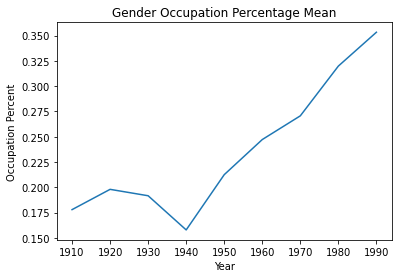

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_chart('Gender Occupation Percentage Mean', 'Year', 'Occupation Percent', ChartInfo('female', all_occups_all_years_female_mean))


In [ ]:
# Relative

all_occups_all_years_female_mean = gender_all_occups_relative_percent(years)
print("female: ", all_occups_all_years_female_mean)

all_occups_all_years_female_mean = gender_all_occups_relative_percent_per_year(years)
print("female: ", all_occups_all_years_female_mean)

female:  -52.94335121075304
female:  {1910: -64.42080311958647, 1920: -60.407146141568816, 1930: -61.67491631276065, 1940: -68.43322178942064, 1950: -57.50425917457691, 1960: -50.55538263149722, 1970: -45.86327076275596, 1980: -36.0206984547329, 1990: -29.326731813073327}


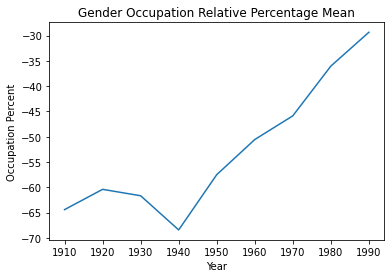

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_chart('Gender Occupation Relative Percentage Mean', 'Year', 'Occupation Percent', ChartInfo('female', all_occups_all_years_female_mean))


In [ ]:
apply_logit_prop = False

hispanic_all_occups_all_years_mean = race_all_occups_percent_per_year("hispanic", years, apply_logit_prop)
print("hispanic: ", hispanic_all_occups_all_years_mean)

black_all_occups_all_years_mean = race_all_occups_percent_per_year("black", years, apply_logit_prop)
print("black: ", black_all_occups_all_years_mean)

asian_all_occups_all_years_mean = race_all_occups_percent_per_year("asian", years, apply_logit_prop)
print("asian: ", asian_all_occups_all_years_mean)

# and relative example (can be negative)
hispanic_rel_all_occups_all_years_mean = race_all_occups_relative_percent_per_year("hispanic", years)
print("hispanic relative: ", hispanic_rel_all_occups_all_years_mean)


hispanic:  {1910: 0.005915974746676009, 1920: 0.007177339676832575, 1930: 0.010279470721832383, 1940: 0.01099297824140071, 1950: 0.0156580525159816, 1960: 0.021396161442331342, 1970: 0.030976671921375695, 1980: 0.04617470987336233, 1990: 0.06611045402203097}
black:  {1910: 0.048270258913171764, 1920: 0.04755116513289124, 1930: 0.053531493019688445, 1940: 0.05370935574951313, 1950: 0.07096388660778224, 1960: 0.0680673466743644, 1970: 0.0725822035048231, 1980: 0.07836652562545487, 1990: 0.08339541933516116}
asian:  {1910: 0.0029481347896677763, 1920: 0.0030079777467855104, 1930: 0.0032557631109124143, 1940: 0.0014460668810149417, 1950: 0.0024807746100990362, 1960: 0.005308901098543822, 1970: 0.009761096043769466, 1980: 0.01947860907825475, 1990: 0.029492577141561158}
hispanic relative:  {1910: -93.59811187702809, 1920: -93.38573626944363, 1930: -92.1374233107298, 1940: -92.20292402469741, 1950: -89.42229239200881, 1960: -88.14418112249982, 1970: -85.21958784587127, 1980: -80.356027641261

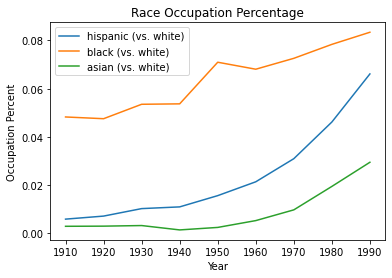

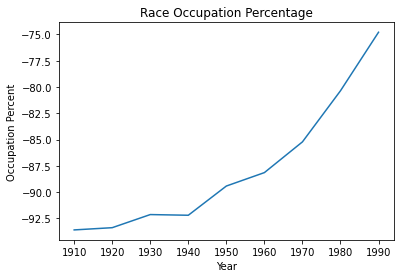

<Figure size 432x288 with 0 Axes>

In [ ]:
hispanic_chart = ChartInfo('hispanic (vs. white)', hispanic_all_occups_all_years_mean)
black_chart = ChartInfo('black (vs. white)', black_all_occups_all_years_mean)
asian_chart = ChartInfo('asian (vs. white)', asian_all_occups_all_years_mean)
plot_charts('Race Occupation Percentage', 'Year', 'Occupation Percent', [hispanic_chart, black_chart, asian_chart])

asian_rel_chart = ChartInfo('asian rel (vs. white)', hispanic_rel_all_occups_all_years_mean)
plot_chart('Race Occupation Percentage', 'Year', 'Occupation Percent', asian_rel_chart)




## Jews and Antisemitism (our innovative part - beyond the original paper)

We have 2 gaps for this work:
1.  We don't have the underlying corpus used: this means we can't recalculate embeddings (with new techniques / parameters - see later under Embedding Bias chapter) or any other metric from the raw data.
2. We don't have Census information about Antisemitism over the years, thus we can't calculate rates (as was done for Occupations).

Nevertheless, we do have some interesting things to test.

### Vocab Frequiencies

First, we define a few group of words that will be relevant for Jewish:

In [ ]:
# Jewish related words:

jewish_occupations =  WordsGroup('jewish_occupations', DataRootPath.GDRIVE)
hate_words =          WordsGroup('hate_words', DataRootPath.GDRIVE)
antisemitism_words =  WordsGroup('antisemitism_words', DataRootPath.GDRIVE)
names_jewish =        WordsGroup('names_jewish', DataRootPath.GDRIVE)

jewish_words_groups = [ jewish_occupations, hate_words, antisemitism_words, names_jewish ]

Than, we use original techniques with this data for Vocab-Frequencies:

In [ ]:
words_groups_to_yearly_avg_count = words_count_avg_per_year(jewish_words_groups, Embedding.SGNS, years)
[print(key,':',value) for key, value in words_groups_to_yearly_avg_count.items()]
print('\n')

jewish_occupations(sgns) : {1910: 210.0, 1920: 178.32608695652175, 1930: 214.58695652173913, 1940: 281.5869565217391, 1950: 440.19565217391306, 1960: 862.695652173913, 1970: 1170.1739130434783, 1980: 1738.3478260869565, 1990: 2892.586956521739}
hate_words(sgns) : {1910: 130253.99206349206, 1920: 114794.5, 1930: 102946.23809523809, 1940: 113568.51587301587, 1950: 155463.17460317462, 1960: 282613.42063492065, 1970: 331924.77777777775, 1980: 386047.20634920633, 1990: 586354.6746031746}
antisemitism_words(sgns) : {1910: 59.75, 1920: 41.333333333333336, 1930: 41.05555555555556, 1940: 30.52777777777778, 1950: 45.5, 1960: 74.11111111111111, 1970: 75.69444444444444, 1980: 85.97222222222223, 1990: 136.80555555555554}
names_jewish(sgns) : {1910: 2646.2, 1920: 2354.45, 1930: 2012.575, 1940: 2057.275, 1950: 3346.85, 1960: 7688.15, 1970: 14201.15, 1980: 19401.975, 1990: 28871.875}




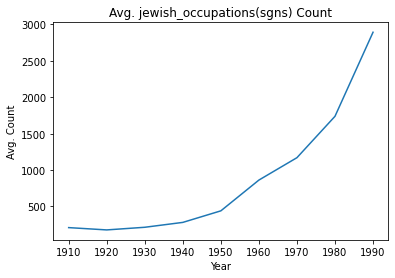

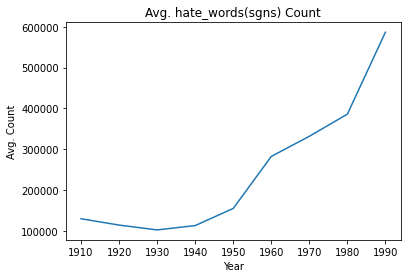

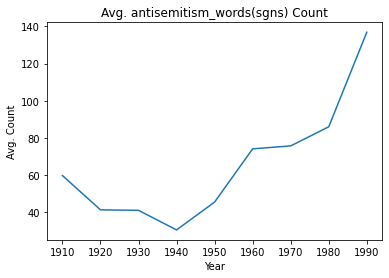

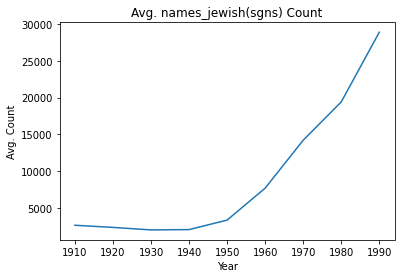

<Figure size 432x288 with 0 Axes>

In [ ]:
charts_info = [ChartInfo(key, value) for key, value in words_groups_to_yearly_avg_count.items()]
# We plot on different charts as the counts are very different (from few dozens to tens of thousants)
for chart_info in charts_info:
  plot_chart('Avg. ' + chart_info.name + ' Count', 'Year', 'Avg. Count', chart_info)

jewish_occupations(sgns) : {1910: 0.0071250548023662295, 1920: 0.006522584637800017, 1930: 0.008547710837079612, 1940: 0.01143125008271159, 1950: 0.011918668097462313, 1960: 0.013239064584834266, 1970: 0.014457360390817539, 1980: 0.017398063454034666, 1990: 0.01913624797106198}
hate_words(sgns) : {1910: 4.4193658651397945, 1920: 4.198807112200533, 1930: 4.100690411320966, 1940: 4.610405689606646, 1950: 4.209296412453022, 1960: 4.337030468275017, 1970: 4.100891398693365, 1980: 3.8637111005771354, 1990: 3.8790980602672085}
antisemitism_words(sgns) : {1910: 0.002027247735435153, 1920: 0.0015118380581905524, 1930: 0.0016353790688531183, 1940: 0.0012392998118869968, 1950: 0.0012319508285835656, 1960: 0.0011373208894485463, 1970: 0.0009351959146566525, 1980: 0.0008604435516645392, 1990: 0.0009050531839768847}
names_jewish(sgns) : {1910: 0.08978247627629293, 1920: 0.08611807538967932, 1930: 0.08016754334363621, 1940: 0.08351674134485311, 1950: 0.09061878309109685, 1960: 0.11798357176300533, 1

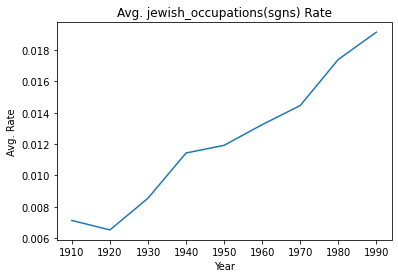

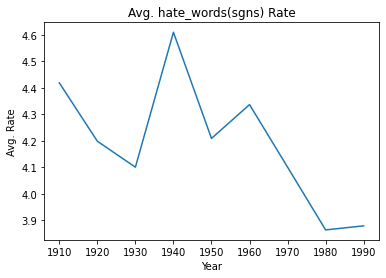

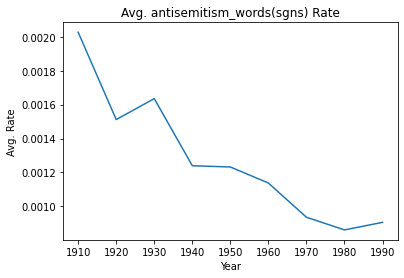

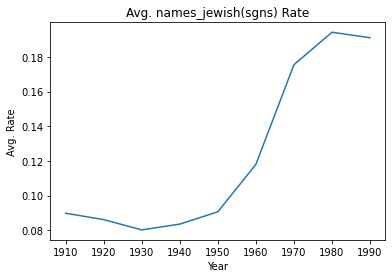

<Figure size 432x288 with 0 Axes>

In [ ]:
# Now, normalize to corpus size:

words_groups_to_yearly_avg_count = words_count_avg_per_year(jewish_words_groups, Embedding.SGNS, years, normalize=True)
[print(key,':',value) for key, value in words_groups_to_yearly_avg_count.items()]
print('\n')

charts_info = [ChartInfo(key, value) for key, value in words_groups_to_yearly_avg_count.items()]
# We plot on different charts as the counts are very different (from few dozens to tens of thousants)
for chart_info in charts_info:
  plot_chart('Avg. ' + chart_info.name + ' Rate', 'Year', 'Avg. Rate', chart_info)


### Embedding Bias

First, we check Occupations of Jewish vs. White:

In [ ]:
# Occupation: Jewish v s. White:
occup_dist_per_year = word_groups_vec_dist(occupation_prof_words_origin, names_white_origin, names_jewish, Embedding.SVD, years)
print(occup_dist_per_year)

# 'Jewish' Occupation: Jewish vs. White:
jewish_occup_dist_per_year = word_groups_vec_dist(jewish_occupations, names_white_origin, names_jewish, Embedding.SVD, years)
print(jewish_occup_dist_per_year)

Calculating distance for 1910...
Calculating distance for 1920...
Calculating distance for 1930...
Calculating distance for 1940...
Calculating distance for 1950...
Calculating distance for 1960...
Calculating distance for 1970...
Calculating distance for 1980...
Calculating distance for 1990...
{1910: 0.1540873742336516, 1920: 0.13703004264397545, 1930: 0.13347180189536045, 1940: 0.133178141200488, 1950: 0.11248774196995814, 1960: 0.11575899173622894, 1970: 0.08705047502754049, 1980: 0.08257153457192001, 1990: 0.06706139473470984}
Calculating distance for 1910...
Calculating distance for 1920...
Calculating distance for 1930...
Calculating distance for 1940...
Calculating distance for 1950...
Calculating distance for 1960...
Calculating distance for 1970...
Calculating distance for 1980...
Calculating distance for 1990...
{1910: 0.2420363933951205, 1920: 0.19749926232948145, 1930: 0.20648378869770445, 1940: 0.19573477414219753, 1950: 0.17867342209374026, 1960: 0.15822325955608696, 197

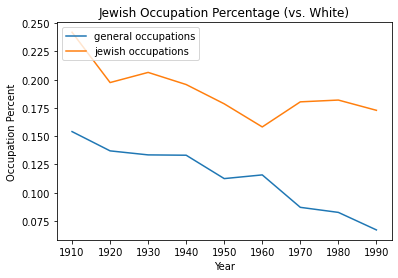

<Figure size 432x288 with 0 Axes>

In [ ]:
occup_chart_info = ChartInfo('general occupations', occup_dist_per_year)
jewish_occup_chart_info = ChartInfo('jewish occupations', jewish_occup_dist_per_year)

plot_charts('Jewish Occupation Percentage (vs. White)', 'Year', 'Occupation Percent', [occup_chart_info, jewish_occup_chart_info])


Than, let's check Hate Words: Jewish vs. White (or other Etnics):

In [ ]:
# Hate words: Jewish vs. White:
hate_jewish_vs_white_dist_per_year = word_groups_vec_dist(hate_words, names_white_origin, names_jewish, Embedding.SVD, years)
print(hate_jewish_vs_white_dist_per_year)

# Hate words: Jewish vs. Black:
hate_jewish_vs_black_dist_per_year = word_groups_vec_dist(hate_words, names_black_origin, names_jewish, Embedding.SVD, years)
print(hate_jewish_vs_black_dist_per_year)

Calculating distance for 1910...
Calculating distance for 1920...
Calculating distance for 1930...
Calculating distance for 1940...
Calculating distance for 1950...
Calculating distance for 1960...
Calculating distance for 1970...
Calculating distance for 1980...
Calculating distance for 1990...
{1910: 0.2020902713270365, 1920: 0.19158754120185995, 1930: 0.185765879557374, 1940: 0.17924091123072983, 1950: 0.16076667886530394, 1960: 0.15958692422310983, 1970: 0.12807710446707565, 1980: 0.11832699052516804, 1990: 0.10366535997396364}
Calculating distance for 1910...
Calculating distance for 1920...
Calculating distance for 1930...
Calculating distance for 1940...
Calculating distance for 1950...
Calculating distance for 1960...
Calculating distance for 1970...
Calculating distance for 1980...
Calculating distance for 1990...
{1910: 0.20931321355793164, 1920: 0.19986136031417812, 1930: 0.19096926055509011, 1940: 0.18394768758727564, 1950: 0.16595419070729767, 1960: 0.16200119018833803, 19

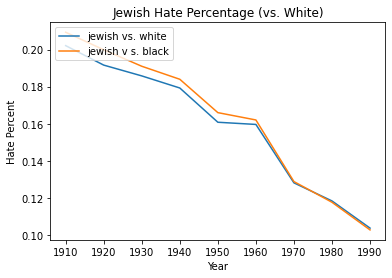

<Figure size 432x288 with 0 Axes>

In [ ]:
hate_jewish_vs_white_chart_info = ChartInfo('jewish vs. white', hate_jewish_vs_white_dist_per_year)
hate_jewish_vs_black_chart_info = ChartInfo('jewish v s. black', hate_jewish_vs_black_dist_per_year)

plot_charts('Jewish Hate Percentage (vs. White)', 'Year', 'Hate Percent', [hate_jewish_vs_white_chart_info, hate_jewish_vs_black_chart_info])


We now want to check phrases (a few words together) as we believe we can be more accurate on what we look for and test. For example, "world domination" is something we want to check but we don't have a good way to do it using the existing (original) embeddings (and counts).
Underlying corpus is not easily acceible which means we can't learn a new model for bi-grams (or n-grams) instead of the given single-words embeddings.

Instead, we generate a bi-gram vector by combining the 2 relevant single word's vectors. We use a few methods for the combination: 
*   vector concatination
*   avgeraging
*   multiplication
*   PCA from 2D to 1D

While we understand it might not be as good as learning bi-grams vectors from the original corpus, it is still a nice concept to check and evaluate. One of the reasons it's not as good is that while doing it we keep the sentence semantic information but we loose the syntax of the sentence. 
Anyhow, we believe average metric is the most natural (thus best) metric for  the embeddings combination.

In [ ]:
# Vectors Combine:

def vec_concat(vec1, vec2):
  # return np.concatenate((vec1, vec2))
  return np.stack([vec1, vec2])

def vec_avg(vec1, vec2):
  return (vec1 + vec2) / 2.0

def vec_mul(vec1, vec2):
  result = np.empty([len(vec1)])
  for ind in range(len(vec1)):
    if vec1[ind] * vec2[ind] >= 0:
      result[ind] = np.sqrt(vec1[ind]*vec2[ind])
    else:
      result[ind] = -np.sqrt(-vec1[ind] * vec2[ind])
  return result

from sklearn.decomposition import PCA

def vec_pca(vec1, vec2):
  pca = PCA(n_components=1)
  x = np.transpose(np.stack([vec1, vec2]))
  return np.transpose(pca.fit_transform(x)).flatten()

class CombineMetricFunc(Enum):
  CONCAT = vec_concat
  AVG = vec_avg
  MUL = vec_mul
  PCA = vec_pca


In [ ]:
def is_single_word(word):
  return not ' ' in word

# Handle single or bi-gram words (as well as single words):
def bi_grams_word_to_vec(word_to_vec_all, word, combine_metric_func: CombineMetricFunc, words_group_name, yearly_words_file):
  if is_single_word(word):
    vec = word_to_vec_all.get(word)
    if vec is None:
      print("word '" + word + "' from group " + words_group_name + " doesn't appear in " + yearly_words_file)
      return None
  else:
    # bi-gram
    word1 = word.split()[0]
    word2 = word.split()[1]

    vec1 = word_to_vec_all.get(word1)
    vec2 = word_to_vec_all.get(word2)
    if vec1 is None:
      print("first word '" + word1 + "' from group " + words_group_name + " doesn't appear in " + yearly_words_file)
      return None
    if vec2 is None:
      print("second word '" + word2 + "' from group " + words_group_name + " doesn't appear in " + yearly_words_file)
      return None

    combined_vec = combine_metric_func(vec1, vec2)
    # print("combined_vec size is ", len(combined_vec))
    vec = combined_vec
  
  return vec

# Updated word_to_vec for bi-grams (as well as single words):
def bigrams_word_to_vec(words_group, embedding: Embedding, year, combine_metric_func: CombineMetricFunc):
  word_to_vec_all, yearly_words_file = word_to_vec_dict(embedding, year)

  words_group_file = words_group.full_path()
  words = [ word.lower().strip() for word in open(words_group_file) ]
  word_to_vec = {}
  for word in words:
    vec = bi_grams_word_to_vec(word_to_vec_all, word, combine_metric_func, words_group.name, yearly_words_file)
    if vec is None:
      pass
    else:
      word_to_vec[word] = vec

  return word_to_vec


In [ ]:
def bigram_word_groups_vec_dist(neutral_words_group, words_group_a, words_group_b, embedding: Embedding, years, combine_metric_func: CombineMetricFunc):
  group_a_dist_per_year = {}
  for year in years:
    print("Calculating distance for " + str(year) + "...")
    neutral_words_to_vec = bigrams_word_to_vec(neutral_words_group, embedding, year, combine_metric_func)
    group_a_words_to_vec = bigrams_word_to_vec(words_group_a, embedding, year, combine_metric_func)
    group_b_words_to_vec = bigrams_word_to_vec(words_group_b, embedding, year, combine_metric_func)

    group_a_mean_vec = vec_mean(list(group_a_words_to_vec.values()))
    group_b_mean_vec = vec_mean(list(group_b_words_to_vec.values()))

    group_a_dist = vec_to_vec_list_dist(group_a_mean_vec, neutral_words_to_vec.values())
    group_b_dist = vec_to_vec_list_dist(group_b_mean_vec, neutral_words_to_vec.values())
    group_a_dist_per_year[year] = group_a_dist - group_b_dist
  
  return group_a_dist_per_year


In [ ]:
# (Jewish related) bi-grams hate words:
hate_bigram_words = WordsGroup('hate_words_bigrams', DataRootPath.GDRIVE)


Now, let's check Hate Bigram Words: Jewish vs. White / Black:

In [ ]:
# Hate words: Jewish vs. White (using AVG combine function):
hate_bi_jewish_vs_white_dist_per_year = bigram_word_groups_vec_dist(hate_bigram_words, names_white_origin, names_jewish, Embedding.SVD, years, CombineMetricFunc.AVG)
print(hate_bi_jewish_vs_white_dist_per_year)

# Hate words: Jewish vs. Black (using AVG combine function):
hate_bi_jewish_vs_black_dist_per_year = bigram_word_groups_vec_dist(hate_bigram_words, names_black_origin, names_jewish, Embedding.SVD, years, CombineMetricFunc.AVG)
print(hate_bi_jewish_vs_black_dist_per_year)

Calculating distance for 1910...
second word 'jihad' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
second word 'genocide' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
second word 'terrorism' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
first word 'slut' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
second word 'dodger' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanc

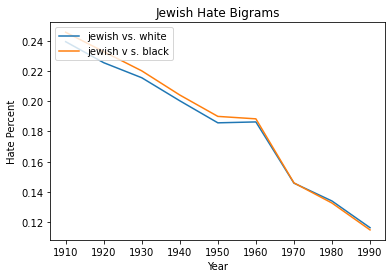

<Figure size 432x288 with 0 Axes>

In [ ]:
hate_bi_jewish_vs_white_chart_info = ChartInfo('jewish vs. white', hate_bi_jewish_vs_white_dist_per_year)
hate_bi_jewish_vs_black_chart_info = ChartInfo('jewish v s. black', hate_bi_jewish_vs_black_dist_per_year)

plot_charts('Jewish Hate Bigrams', 'Year', 'Hate Percent', [hate_bi_jewish_vs_white_chart_info, hate_bi_jewish_vs_black_chart_info])


In [ ]:
# Now, let's compare the 4 combine finctions:
# Hate words: Jewish vs. White (using all 4 combine functions):
avg_hate_bi_jewish_vs_white_dist_per_year = bigram_word_groups_vec_dist(hate_bigram_words, names_white_origin, names_jewish, Embedding.SVD, years, CombineMetricFunc.AVG)
mul_hate_bi_jewish_vs_white_dist_per_year = bigram_word_groups_vec_dist(hate_bigram_words, names_white_origin, names_jewish, Embedding.SVD, years, CombineMetricFunc.MUL)
concat_hate_bi_jewish_vs_white_dist_per_year = bigram_word_groups_vec_dist(hate_bigram_words, names_white_origin, names_jewish, Embedding.SVD, years, CombineMetricFunc.CONCAT)
pca_hate_bi_jewish_vs_white_dist_per_year = bigram_word_groups_vec_dist(hate_bigram_words, names_white_origin, names_jewish, Embedding.SVD, years, CombineMetricFunc.PCA)

avg_hate_bi_jewish_vs_white_chart_info = ChartInfo('bigrams - avg', hate_bi_jewish_vs_white_dist_per_year)
mul_hate_bi_jewish_vs_white_chart_info = ChartInfo('bigrams - mul', mul_hate_bi_jewish_vs_white_dist_per_year)
concat_hate_bi_jewish_vs_white_chart_info = ChartInfo('bigrams - concat', concat_hate_bi_jewish_vs_white_dist_per_year)
pca_hate_bi_jewish_vs_white_chart_info = ChartInfo('bigrams - pca', pca_hate_bi_jewish_vs_white_dist_per_year)


Calculating distance for 1910...
second word 'jihad' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
second word 'genocide' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
second word 'terrorism' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
first word 'slut' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
second word 'dodger' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanc

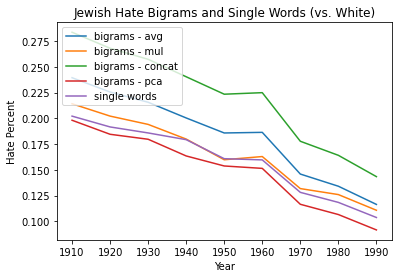

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot it (along with the single-words):

hate_single_words_jewish_vs_white_chart_info = ChartInfo('single words', hate_jewish_vs_white_dist_per_year)

plot_charts('Jewish Hate Bigrams and Single Words (vs. White)', 'Year', 'Hate Percent', 
            [avg_hate_bi_jewish_vs_white_chart_info, 
             mul_hate_bi_jewish_vs_white_chart_info, 
             concat_hate_bi_jewish_vs_white_chart_info, 
             pca_hate_bi_jewish_vs_white_chart_info, 
             hate_single_words_jewish_vs_white_chart_info])


Embedding Distance over the years between some pair of hate-bigrams:

In [ ]:
# Bigrams we want to check correlation between:

# world_domination <-> jewish_money
# world_domination <-> christ_killer
# money_launderers <-> christ_killer
# jewish_people <-> gas_chambers
# jewish_people <-> gas_chamber

world_domination = "world domination"
jewish_money = "jewish money"
christ_killer = "christ killer"
money_launderers = "money launderers"
jewish_people = "jewish people"
gas_chambers = "gas chambers"
gas_chamber = "gas chamber"


In [ ]:
def bigrams_vec_dist(bigrams1, bigrams2, embedding: Embedding, years, combine_metric_func: CombineMetricFunc):
  dist_per_year = {}
  for year in years:
    word_to_vec_all, yearly_words_file = word_to_vec_dict(embedding, year)
    bigrams1_vec = bi_grams_word_to_vec(word_to_vec_all, bigrams1, combine_metric_func, hate_bigram_words.name, yearly_words_file)
    bigrams2_vec = bi_grams_word_to_vec(word_to_vec_all, bigrams2, combine_metric_func, hate_bigram_words.name, yearly_words_file)
    if bigrams1_vec is None or bigrams2_vec is None:
      dist_per_year[year] = None
    else:
      dist_per_year[year] = vec_dist(bigrams1_vec, bigrams2_vec)
  
  return dist_per_year


In [ ]:
# world_domination <-> jewish_money
bigrams1 = world_domination
bigrams2 = jewish_money

avg_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.AVG)
print("avg: ", avg_dist)
mul_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.MUL)
print("mul: ", mul_dist)
concat_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.CONCAT)
print("concat: ", concat_dist)
pca_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.PCA)
print("pca: ", pca_dist)


avg:  {1910: 0.8597013002184992, 1920: 0.852238184121846, 1930: 0.8400799271739932, 1940: 0.8728802081399322, 1950: 0.8492133693904357, 1960: 0.8532091715140617, 1970: 0.8595639949596551, 1980: 0.8478734722111604, 1990: 0.8492828881227056}
mul:  {1910: 1.0915962013538354, 1920: 1.087921696973062, 1930: 1.0789137722984639, 1940: 1.0559687296584912, 1950: 1.0780795086781045, 1960: 1.0568565309401277, 1970: 1.057098404575727, 1980: 1.0530454377192784, 1990: 1.0840860833647592}
concat:  {1910: 1.7256768661730144, 1920: 1.7146502385188411, 1930: 1.7078025324501762, 1940: 1.7120641506641134, 1950: 1.6943334058301267, 1960: 1.6815589366930144, 1970: 1.6900939118962544, 1980: 1.6810737061048544, 1990: 1.69793452282933}
pca:  {1910: 1.2101459267643138, 1920: 1.1988771670974843, 1930: 1.1830416456074524, 1940: 1.2299781819294189, 1950: 1.1930516962817663, 1960: 1.2053464739836366, 1970: 1.2114355324815067, 1980: 1.196158508101884, 1990: 1.1964103103452195}


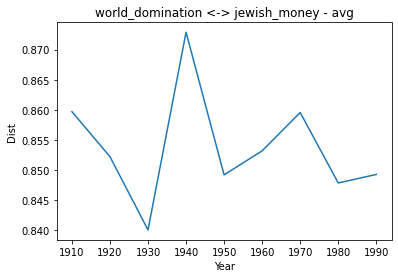

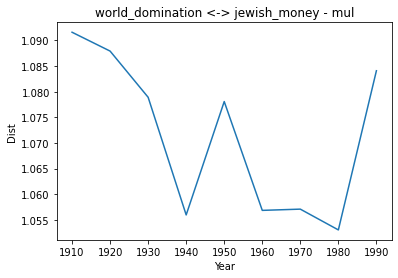

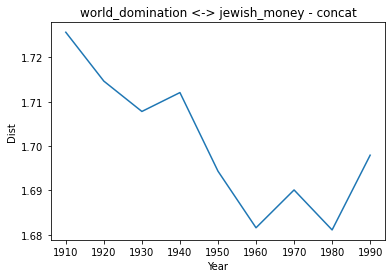

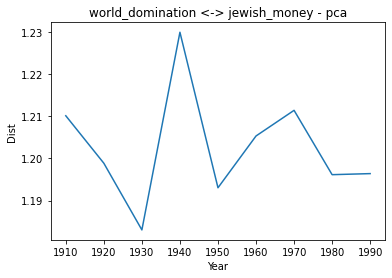

<Figure size 432x288 with 0 Axes>

In [ ]:
title = 'world_domination <-> jewish_money'

avg_chart_info = ChartInfo('avg', avg_dist)
mul_chart_info = ChartInfo('mul', mul_dist)
concat_chart_info = ChartInfo('concat', concat_dist)
pca_chart_info = ChartInfo('pca', pca_dist)
plot_chart(title + ' - avg', 'Year', 'Dist', avg_chart_info)
plot_chart(title + ' - mul', 'Year', 'Dist', mul_chart_info)
plot_chart(title + ' - concat', 'Year', 'Dist', concat_chart_info)
plot_chart(title + ' - pca', 'Year', 'Dist', pca_chart_info)


In [ ]:
# world_domination <-> christ_killer
bigrams1 = world_domination
bigrams2 = christ_killer

avg_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.AVG)
print("avg: ", avg_dist)
mul_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.MUL)
print("mul: ", mul_dist)
concat_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.CONCAT)
print("concat: ", concat_dist)
pca_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.PCA)
print("pca: ", pca_dist)


avg:  {1910: 0.937223441136657, 1920: 0.9569220932630315, 1930: 0.9732244321777377, 1940: 0.99830423843673, 1950: 0.9935365241217498, 1960: 0.9921331186353111, 1970: 0.9837374949515654, 1980: 0.9963873701918753, 1990: 0.9755173752964555}
mul:  {1910: 0.8999780599491204, 1920: 0.9092516175589695, 1930: 0.9287678231981981, 1940: 0.9643266895663248, 1950: 0.9132983257076644, 1960: 0.9035664335650029, 1970: 0.8884788674903298, 1980: 0.9096034318448023, 1990: 0.9295693704151837}
concat:  {1910: 1.7537868278099922, 1920: 1.784712835198717, 1930: 1.7924413990674097, 1940: 1.795097654541213, 1950: 1.7893082339090802, 1960: 1.7848898491425218, 1970: 1.7692321918770497, 1980: 1.8007841127921482, 1990: 1.7835270028602597}
pca:  {1910: 1.3177790868811416, 1920: 1.3506857843558888, 1930: 1.375520940813783, 1940: 1.4116950984085987, 1950: 1.4050698698194026, 1960: 1.4030679613233012, 1970: 1.3909930331493323, 1980: 1.4094251160473061, 1990: 1.3792253088263076}


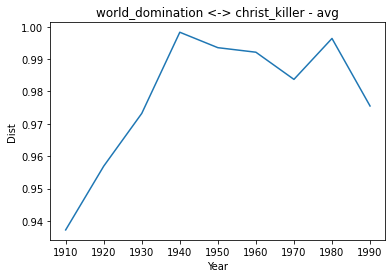

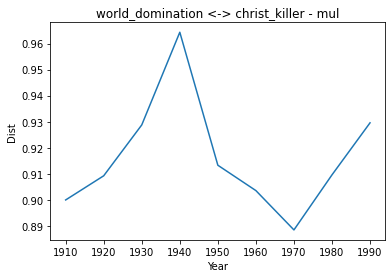

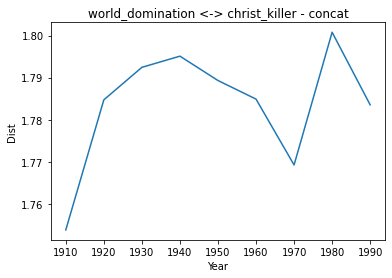

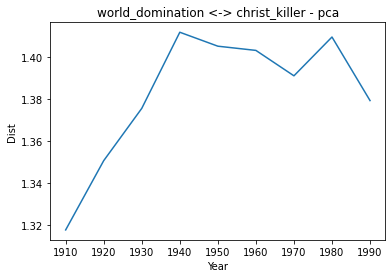

<Figure size 432x288 with 0 Axes>

In [ ]:
title = 'world_domination <-> christ_killer'

avg_chart_info = ChartInfo('avg', avg_dist)
mul_chart_info = ChartInfo('mul', mul_dist)
concat_chart_info = ChartInfo('concat', concat_dist)
pca_chart_info = ChartInfo('pca', pca_dist)
# plot_charts(title, 'Year', 'Dist', [avg_chart_info, mul_chart_info, concat_chart_info, pca_chart_info])
plot_chart(title + ' - avg', 'Year', 'Dist', avg_chart_info)
plot_chart(title + ' - mul', 'Year', 'Dist', mul_chart_info)
plot_chart(title + ' - concat', 'Year', 'Dist', concat_chart_info)
plot_chart(title + ' - pca', 'Year', 'Dist', pca_chart_info)



In [ ]:
# money_launderers <-> christ_killer
bigrams1 = money_launderers
bigrams2 = christ_killer

avg_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.AVG)
print("avg: ", avg_dist)
mul_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.MUL)
print("mul: ", mul_dist)
concat_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.CONCAT)
print("concat: ", concat_dist)
pca_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.PCA)
print("pca: ", pca_dist)


second word 'launderers' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1910-vocab.pkl
second word 'launderers' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1920-vocab.pkl
second word 'launderers' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1930-vocab.pkl
second word 'launderers' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Learning/final project/Final Project Data-Set/eng-all/svd/1940-vocab.pkl
second word 'launderers' from group hate_words_bigrams doesn't appear in /content/gdrive/MyDrive/Data Science Master/2021-B Advanced Machine Lea

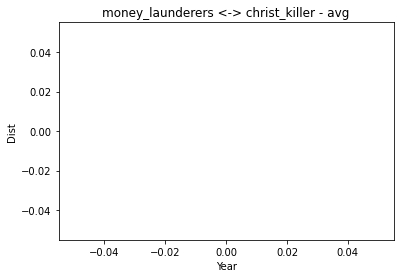

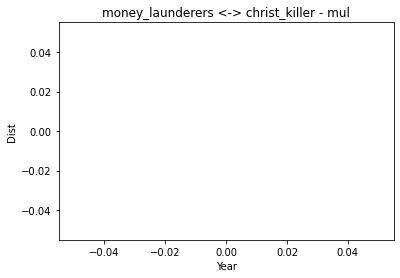

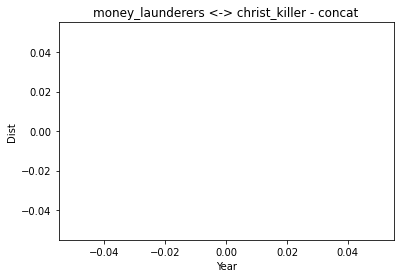

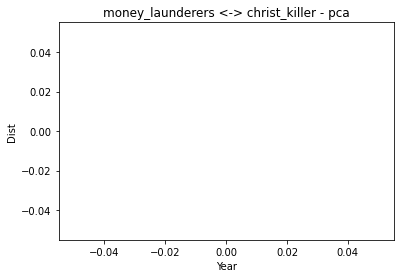

<Figure size 432x288 with 0 Axes>

In [ ]:
title = 'money_launderers <-> christ_killer'

avg_chart_info = ChartInfo('avg', avg_dist)
mul_chart_info = ChartInfo('mul', mul_dist)
concat_chart_info = ChartInfo('concat', concat_dist)
pca_chart_info = ChartInfo('pca', pca_dist)
# plot_charts(title, 'Year', 'Dist', [avg_chart_info, mul_chart_info, concat_chart_info, pca_chart_info])
plot_chart(title + ' - avg', 'Year', 'Dist', avg_chart_info)
plot_chart(title + ' - mul', 'Year', 'Dist', mul_chart_info)
plot_chart(title + ' - concat', 'Year', 'Dist', concat_chart_info)
plot_chart(title + ' - pca', 'Year', 'Dist', pca_chart_info)


In [ ]:
# jewish_people <-> gas_chambers
bigrams1 = jewish_people
bigrams2 = gas_chambers

avg_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.AVG)
print("avg: ", avg_dist)
mul_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.MUL)
print("mul: ", mul_dist)
concat_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.CONCAT)
print("concat: ", concat_dist)
pca_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.PCA)
print("pca: ", pca_dist)


avg:  {1910: 1.039214955022829, 1920: 1.041347828341472, 1930: 1.0245654047001247, 1940: 1.05207308537836, 1950: 1.052591349764155, 1960: 1.0363970427653266, 1970: 1.0416125256512394, 1980: 1.0386640890549665, 1990: 1.0360233100899532}
mul:  {1910: 1.1206182775181117, 1920: 1.121420312459072, 1930: 1.1179577106077025, 1940: 1.084103512798388, 1950: 1.0893171565134907, 1960: 1.0967927240696658, 1970: 1.0560831673731959, 1980: 1.0433183983229979, 1990: 1.073765463177752}
concat:  {1910: 1.8872065083271785, 1920: 1.8845060597497147, 1930: 1.8730523601389564, 1940: 1.8898554503280336, 1950: 1.8824687883665507, 1960: 1.8746202080152397, 1970: 1.8876695289672618, 1980: 1.877178762925464, 1990: 1.8755509700761306}
pca:  {1910: 1.4643736037843447, 1920: 1.466149133838307, 1930: 1.4444383188926802, 1940: 1.4827986946142098, 1950: 1.4855711771780533, 1960: 1.4621593379811735, 1970: 1.471012344108351, 1980: 1.466807428639224, 1990: 1.463410186052132}


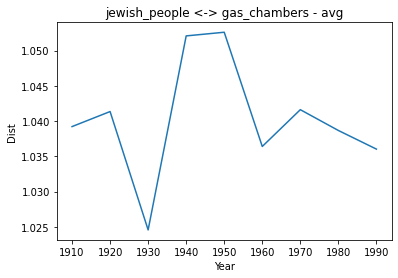

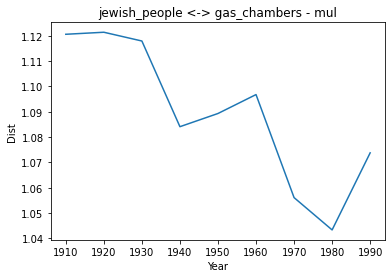

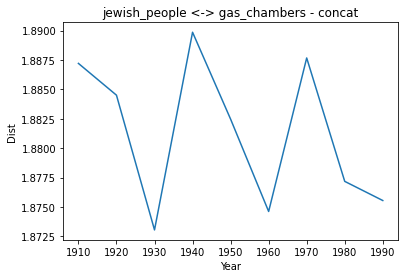

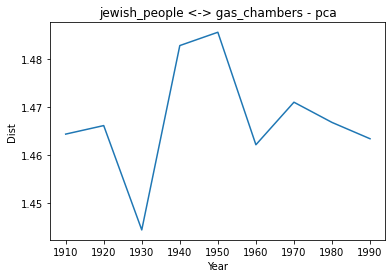

<Figure size 432x288 with 0 Axes>

In [ ]:
title = 'jewish_people <-> gas_chambers'

avg_chart_info = ChartInfo('avg', avg_dist)
mul_chart_info = ChartInfo('mul', mul_dist)
concat_chart_info = ChartInfo('concat', concat_dist)
pca_chart_info = ChartInfo('pca', pca_dist)
# plot_charts(title, 'Year', 'Dist', [avg_chart_info, mul_chart_info, concat_chart_info, pca_chart_info])
plot_chart(title + ' - avg', 'Year', 'Dist', avg_chart_info)
plot_chart(title + ' - mul', 'Year', 'Dist', mul_chart_info)
plot_chart(title + ' - concat', 'Year', 'Dist', concat_chart_info)
plot_chart(title + ' - pca', 'Year', 'Dist', pca_chart_info)


In [393]:
# jewish <-> gas_chambers
jewish = "jewish"
word1 = jewish
bigrams2 = gas_chambers

avg_dist = bigrams_vec_dist(word1, bigrams2, Embedding.SVD, years, CombineMetricFunc.AVG)
print("avg: ", avg_dist)
mul_dist = bigrams_vec_dist(word1, bigrams2, Embedding.SVD, years, CombineMetricFunc.MUL)
print("mul: ", mul_dist)
concat_dist = bigrams_vec_dist(word1, bigrams2, Embedding.SVD, years, CombineMetricFunc.CONCAT)
print("concat: ", concat_dist)
pca_dist = bigrams_vec_dist(word1, bigrams2, Embedding.SVD, years, CombineMetricFunc.PCA)
print("pca: ", pca_dist)


avg:  {1910: 1.1925698535976346, 1920: 1.1844973181503682, 1930: 1.1658814955504317, 1940: 1.1643498798397685, 1950: 1.181272492039177, 1960: 1.1520350144939897, 1970: 1.1542795081322594, 1980: 1.1684284994286631, 1990: 1.183507018604231}
mul:  {1910: 1.1486471419429578, 1920: 1.1673197582205508, 1930: 1.1757751519280928, 1940: 1.1691673606066533, 1950: 1.1805075811238426, 1960: 1.1677047795919648, 1970: 1.1720190337913456, 1980: 1.1800246145159117, 1990: 1.1555510748917457}
concat:  {1910: 1.9147871880025955, 1920: 1.9028908456941065, 1930: 1.8850422613232207, 1940: 1.8653088585615298, 1950: 1.880940367874265, 1960: 1.8412555934274875, 1970: 1.8387953703310262, 1980: 1.8494904999379949, 1990: 1.862864511140528}
pca:  {1910: 1.389234978881769, 1920: 1.3799840315744487, 1930: 1.357896314513508, 1940: 1.3621407642586367, 1950: 1.3854944726131146, 1960: 1.350863529561107, 1970: 1.3582317645718784, 1980: 1.3779218020384079, 1990: 1.3982377635665157}


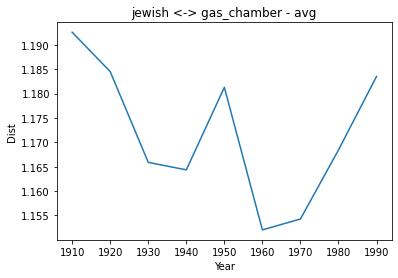

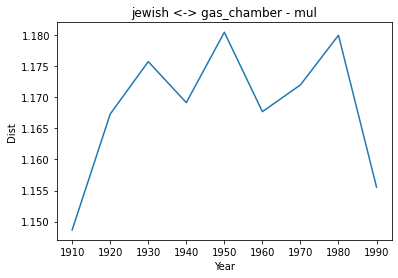

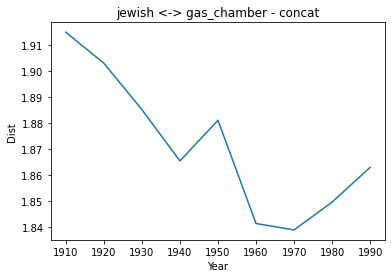

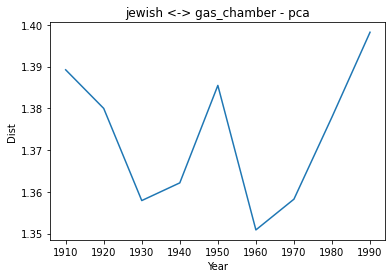

<Figure size 432x288 with 0 Axes>

In [394]:
title = 'jewish <-> gas_chamber'

avg_chart_info = ChartInfo('avg', avg_dist)
mul_chart_info = ChartInfo('mul', mul_dist)
concat_chart_info = ChartInfo('concat', concat_dist)
pca_chart_info = ChartInfo('pca', pca_dist)
# plot_charts(title, 'Year', 'Dist', [avg_chart_info, mul_chart_info, concat_chart_info, pca_chart_info])
plot_chart(title + ' - avg', 'Year', 'Dist', avg_chart_info)
plot_chart(title + ' - mul', 'Year', 'Dist', mul_chart_info)
plot_chart(title + ' - concat', 'Year', 'Dist', concat_chart_info)
plot_chart(title + ' - pca', 'Year', 'Dist', pca_chart_info)


In [398]:
# jewish <-> gas
jewish = "jewish"
gas = "gas"
word1 = jewish
word2 = gas

# combine function not used (as these are single words):
dist = bigrams_vec_dist(word1, word2, Embedding.SVD, years, CombineMetricFunc.AVG)
print("dist ", dist)


dist  {1910: 1.3902530465834766, 1920: 1.386270210968499, 1930: 1.3837400906847106, 1940: 1.38424851562395, 1950: 1.39261288896915, 1960: 1.3794386436805905, 1970: 1.3822566557092009, 1980: 1.3800810671656252, 1990: 1.3875498094239305}


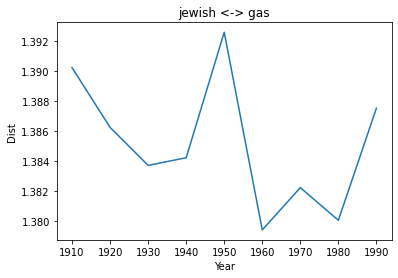

<Figure size 432x288 with 0 Axes>

In [399]:
title = 'jewish <-> gas'
chart_info = ChartInfo('', dist)
plot_chart(title, 'Year', 'Dist', chart_info)


In [ ]:
# jewish_people <-> gas_chamber
bigrams1 = jewish_people
bigrams2 = gas_chamber

avg_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.AVG)
print("avg: ", avg_dist)
mul_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.MUL)
print("mul: ", mul_dist)
concat_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.CONCAT)
print("concat: ", concat_dist)
pca_dist = bigrams_vec_dist(bigrams1, bigrams2, Embedding.SVD, years, CombineMetricFunc.PCA)
print("pca: ", pca_dist)


avg:  {1910: 1.0900078053312494, 1920: 1.0867915491922298, 1930: 1.0862679274771576, 1940: 1.1145250668930728, 1950: 1.1194119738058992, 1960: 1.105380472614117, 1970: 1.1058892734234194, 1980: 1.1038523203867732, 1990: 1.1135585542264785}
mul:  {1910: 1.1171669885312299, 1920: 1.1058287571905407, 1930: 1.097836667504109, 1940: 1.0519791678476655, 1950: 1.052358347987078, 1960: 1.0531773446917512, 1970: 1.034869391123656, 1980: 1.0495316883154797, 1990: 1.0357483700085146}
concat:  {1910: 1.9097944878262574, 1920: 1.9079311491319788, 1930: 1.9047119153546008, 1940: 1.9138239419038487, 1950: 1.916751559727391, 1960: 1.9077873149096958, 1970: 1.9178750874551387, 1980: 1.9130918417096652, 1990: 1.9211265488805915}
pca:  {1910: 1.5347745636695604, 1920: 1.5307007111576783, 1930: 1.5323230558281598, 1940: 1.5709422375753896, 1950: 1.5793852216710256, 1960: 1.55967291720261, 1970: 1.5627725401588508, 1980: 1.5600826318907914, 1990: 1.5734117327925403}


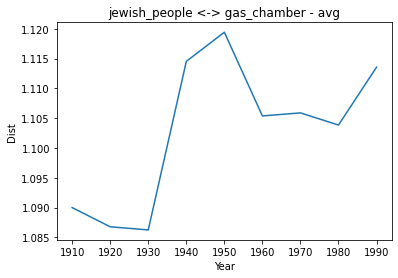

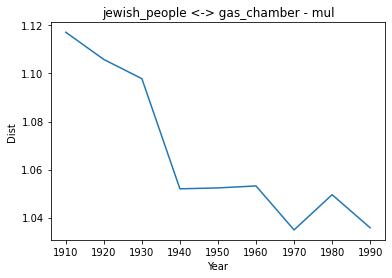

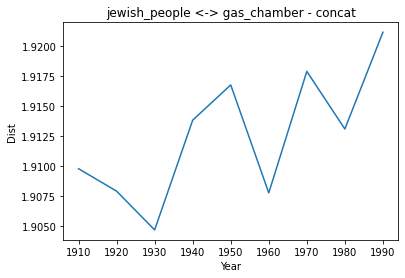

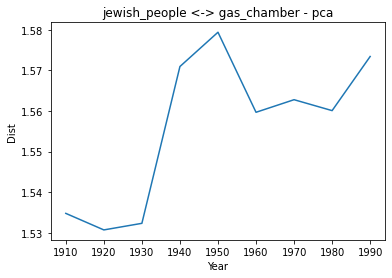

<Figure size 432x288 with 0 Axes>

In [ ]:
title = 'jewish_people <-> gas_chamber'

avg_chart_info = ChartInfo('avg', avg_dist)
mul_chart_info = ChartInfo('mul', mul_dist)
concat_chart_info = ChartInfo('concat', concat_dist)
pca_chart_info = ChartInfo('pca', pca_dist)
# plot_charts(title, 'Year', 'Dist', [avg_chart_info, mul_chart_info, concat_chart_info, pca_chart_info])
plot_chart(title + ' - avg', 'Year', 'Dist', avg_chart_info)
plot_chart(title + ' - mul', 'Year', 'Dist', mul_chart_info)
plot_chart(title + ' - concat', 'Year', 'Dist', concat_chart_info)
plot_chart(title + ' - pca', 'Year', 'Dist', pca_chart_info)


# The End!